# Spatial Data for NEP36-CanOE

February 2021

James Munroe

## Tasks

1. For 3 different simulations: historical, RCP4.5, RCP 8.5 generate benthic and surface layers for: O2, PH, T, S, NO3, integrated PP, speed, MLD. 
- These should be generated in a tiff format. The TIFF files should be georeferenced (contain projection information, even if layers are WGS84 – unprojected. GIS hub primarily uses the BC Albers projection (EPSG: 3005). 
- These should be calculated for spring/summer and fall/winter 
- Total layers: 3 simulations*( 6vars*2+ 1PP +1MLD) = 42 layers 
- Standardized names should be used that correspond to existing nomenclature (ie. NEP36-CanOE_historical_1986-2005_varname_season_bottom.tif) 


### Import required Python packages

This notebooks is primarily using the Xarray package with the rioxarray add-on.  Matplotlib is used to verify the results.

In [1]:
import rioxarray
import xarray as xr

import glob
import os
import subprocess
import re

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


## Incoming datasets

The incoming datasets need to accesible to this notebook.  

In [2]:
input_dir = './NEP36-CanOE_masked_715'

We are ssuming that there is a local directory called `NEP36-CanOE_masked_715` that either contains or is symlinked to the output for the different simulation.  If this is not the case please adjust the path above.

Here are the simulations that need to be processed. 

In [3]:
simulations = ['historical_1986-2005', 
               'RCP45_2046-2065', 
               'RCP85_2046-2065']

We need to assume the filenames have a given pattern

In [4]:
ncfile_pattern = 'NEP36-CanOE_{variable}_{simulation}_monthly_715x715_mask.nc'

Start by confirming there are netCDF files where we are expecting them and that they have this naming pattern.

In [5]:
heading = f'Looking for NetCDF files in {input_dir}'

print(heading)
print('-'*len(heading))
all_variables = []
for simulation in simulations:
    simulation_shortname = simulation.split('_')[0]
    
    path = os.path.join(input_dir, simulation_shortname)
    
    regex = os.path.join(path, ncfile_pattern.format(variable='(.*)', simulation=simulation))
    m = re.compile(regex)
    
    ncfiles = glob.glob(os.path.join(path, '*.nc'))
    variables = []
    for ncfile in ncfiles:
        matches = m.match(ncfile)
        if matches is not None:
            variable = m.match(ncfile).group(1)
            variables.append(variable)            
            
    all_variables.extend(variables)
    
    print(f'  {simulation:25} {len(variables)}/{len(ncfiles)} files matched')
all_variables = list(set(all_variables))
print('\nFile name pattern:', ncfile_pattern)
print(f'Total variables found: {len(all_variables)}')
print(f'{all_variables}')

Looking for NetCDF files in ./NEP36-CanOE_masked_715
----------------------------------------------------
  historical_1986-2005      20/20 files matched
  RCP45_2046-2065           20/20 files matched
  RCP85_2046-2065           20/20 files matched

File name pattern: NEP36-CanOE_{variable}_{simulation}_monthly_715x715_mask.nc
Total variables found: 20
['maxPH', 'omega_a', 'Cflx', 'DIC', 'TCHL', 'Alkalini', 'TPP', 'mintemp', 'speed', 'NO3', 'mld', 'O2', 'temp', 'minO2', 'maxtemp', 'minPH', 'PH', 'sigma', 'salt', 'maxO2']


Hopefully, the number of variables matches the number the number of files in each simulation.  If this is not so modify `ncfile_pattern` as required.

## Opening a netCDF file with xarray

To open a netCDF file using `xarray` we use the `.open_dataset()` method.

In [6]:
variable = 'temp'
simulation = 'historical_1986-2005'

simulation_shortname = simulation.split('_')[0]
path = os.path.join(input_dir, simulation_shortname)
ncfile = os.path.join(path, ncfile_pattern.format(variable=variable, simulation=simulation))

print(f'Opening {ncfile}')
ds = xr.open_dataset(ncfile)

Opening ./NEP36-CanOE_masked_715/historical/NEP36-CanOE_temp_historical_1986-2005_monthly_715x715_mask.nc


In [7]:
darr = ds[variable]
darr

<xarray.DataArray 'temp' (t: 12, deptht: 50, lat: 715, lon: 715)>
[306735000 values with dtype=float32]
Coordinates:
  * deptht   (deptht) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * lat      (lat) float32 44.33 44.35 44.38 44.4 ... 59.55 59.57 59.59 59.61
  * lon      (lon) float32 -142.3 -142.3 -142.2 -142.2 ... -120.6 -120.6 -120.6
  * t        (t) float32 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 12.5
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      temperature
    units:          degC

## Assign months to "seasons"

The time index is given units of *months* evaluated at the middle of the month.

In [8]:
darr.t.values

array([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5,
       12.5], dtype=float32)

We want to group the data by season (*fallwinter* or *springsummer*) so we redefine the times accordingly:

In [9]:
darr['t'] = ['fallwinter', 'fallwinter', 'springsummer',     # JFM
           'springsummer', 'springsummer', 'springsummer', # AMJ
           'springsummer', 'springsummer', 'fallwinter',   # JAS
           'fallwinter', 'fallwinter', 'fallwinter'        # OND
          ]

### Extracting surface and bottom layers

We can extract the surface layer by retrieving only the data at with `deptht = 0`. The "depth" index is set to 0 everywhere.

In [10]:
deptht_index = 0
darr_surface = darr.isel(deptht=deptht_index)

To extract the benthic layer, we first determine the depth at each grid point and then use that to look up the value for the bottom layer.

(*Note: use of Dask to parallelize this operation is not yet supported by the library. Leaving the array as a DaskArray wil lead to `TypeError: unexpected indexer type for VectorizedIndexer` exceptions. This is known limitation of Xarray/Dask and is currently marked as an [open issue](https://github.com/pydata/xarray/issues/2511) on GitHub. This is why we are explicitly loading the array into RAM.*)

In [11]:
%%time
deptht_index = darr.notnull().sum('deptht') - 1
darr_bottom = darr.isel(deptht=deptht_index)

CPU times: user 15.6 s, sys: 2.23 s, total: 17.8 s
Wall time: 17.8 s


Due to the loading all of the data into memory, this step is somewhat expensive, but only needs to be run once per NetCDF file.

## Average over seasons

We can then group the data by seaon and compute the mean.

In [12]:
darr_surface_mean = darr_surface.groupby('t').mean('t')
darr_bottom_mean = darr_bottom.groupby('t').mean('t')

## Verification of results

Here is a plot for the temperature field along the surface and benthic layer for the two "seasons".

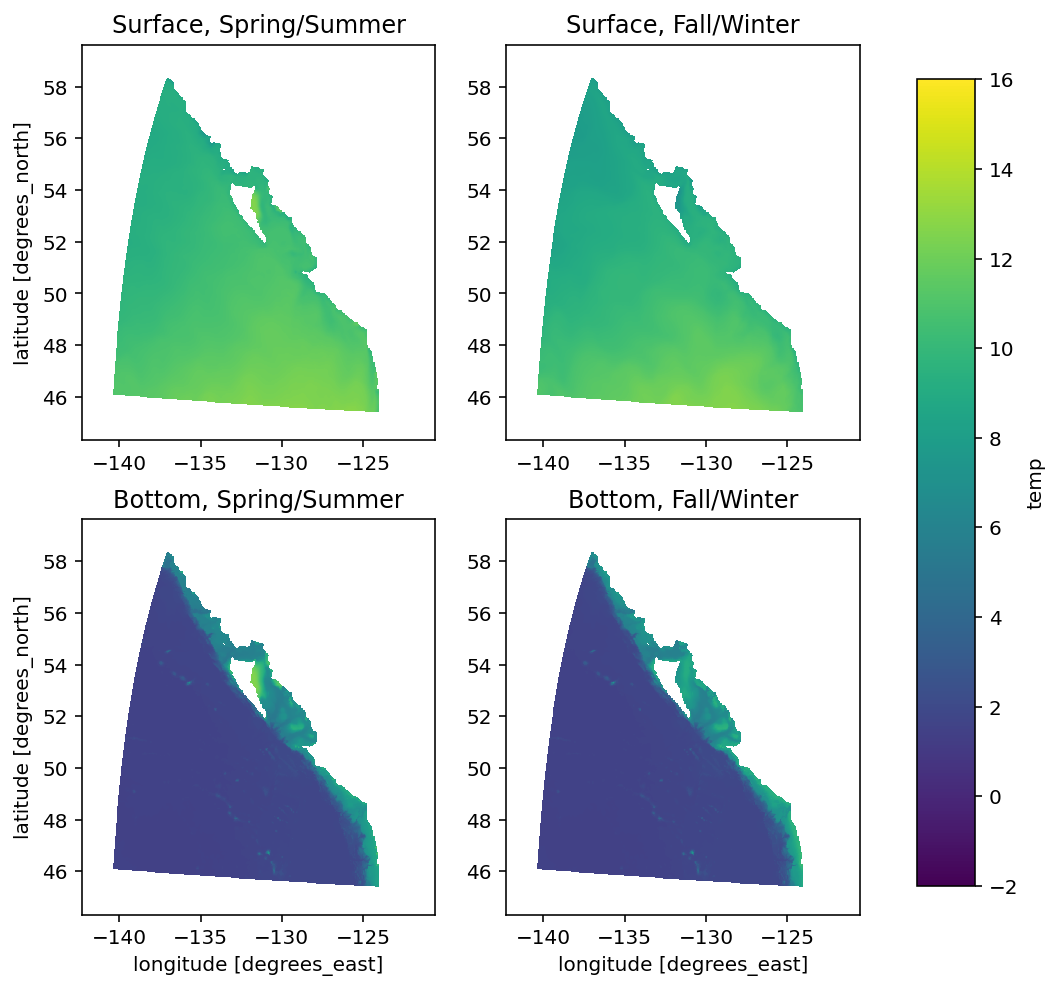

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
kwargs = {'vmin':-2, 'vmax':16, 'add_colorbar': False}

p1 = darr_surface_mean.sel(t='springsummer').plot(ax=ax1, **kwargs)
ax1.set_title('Surface, Spring/Summer'); ax1.set_xlabel('')
p2 = darr_surface_mean.sel(t='fallwinter').plot(ax=ax2, **kwargs)
ax2.set_title('Surface, Fall/Winter'); ax2.set_xlabel(''); ax2.set_ylabel('')
p3 = darr_bottom_mean.sel(t='springsummer').plot(ax=ax3, **kwargs)
ax3.set_title('Bottom, Spring/Summer'); 
p4 = darr_bottom_mean.sel(t='fallwinter').plot(ax=ax4, **kwargs)
ax4.set_title('Bottom, Fall/Winter'); ax4.set_ylabel('')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(p4, cax=cbar_ax)
cbar.set_label(variable)

plt.show()

## Output of GeoTIFF files

We want to save the converted files as GeoTIFF with the naming pattern

In [14]:
outfile_pattern = 'NEP36-CanOE_{simulation}_{variable}_{season}_{level}.tif'

For example, here we save the bottom layer for temperature averaged over the fall/winter season:

In [15]:
filename = outfile_pattern.format(variable=variable, 
                                  simulation=simulation,
                                  season='fallwinter',
                                  level='bottom')

darr_bottom_mean.rio.set_crs('EPSG:4362', inplace=True) 
darr_bottom_mean.rio.to_raster(filename)

Here is the metadata in the GeoTIFF file showing that the correct CRS has been defined.

In [16]:
!rio info NEP36-CanOE_historical_1986-2005_temp_fallwinter_bottom.tif

{"bounds": [-142.29837702369156, 59.62234430553533, -120.55606175804672, 44.32197255847835], "colorinterp": ["gray", "undefined"], "count": 2, "crs": "GEOCCS[\"NAD83(HARN) (geocentric)\",DATUM[\"NAD83_High_Accuracy_Reference_Network\",SPHEROID[\"GRS 1980\",6378137,298.257222101004,AUTHORITY[\"EPSG\",\"7019\"]],AUTHORITY[\"EPSG\",\"6152\"]],PRIMEM[\"Greenwich\",0],UNIT[\"metre\",1],AXIS[\"Geocentric X\",OTHER],AXIS[\"Geocentric Y\",OTHER],AXIS[\"Geocentric Z\",NORTH]]", "descriptions": ["temp", "temp"], "driver": "GTiff", "dtype": "float32", "height": 715, "indexes": [1, 2], "interleave": "pixel", "lnglat": [158.42395754330963, 90.0], "mask_flags": [["all_valid"], ["all_valid"]], "nodata": null, "res": [0.0304088325393634, -0.021399121324555213], "shape": [715, 715], "tiled": false, "transform": [0.0304088325393634, 0.0, -142.29837702369156, 0.0, 0.021399121324555213, 44.32197255847835, 0.0, 0.0, 1.0], "units": [null, null], "width": 715}


The above approach will work for any full-depth variable such as temperature, salinity, pH, speed, O2, or NO3.

## Complete implementation

We can combine all of the above steps into a single function:

In [3]:
input_dir = './NEP36-CanOE_masked_715'
ncfile_pattern = 'NEP36-CanOE_{variable}_{simulation}_monthly_715x715_mask.nc'
outfile_pattern = 'NEP36-CanOE_{simulation}_{variable}_{season}_{level}.tif'

def process_climate_output(simulation, variable, force=True):
    
    print(f'Processing {simulation} for {variable}...')
    
    # skip processing if output files already exist
    allFilesFound = True
    for level in ['surface', 'bottom']:
        for season in ['springsummer', 'fallwinter']:
            filename = outfile_pattern.format(variable=variable, 
                                  simulation=simulation,
                                  season=season,
                                  level=level)
            allFilesFound &= os.path.exists(filename)
    if allFilesFound and not force:
        return
    
    simulation_shortname = simulation.split('_')[0]
    
    path = os.path.join(input_dir, simulation_shortname)
    ncfile = os.path.join(path, ncfile_pattern.format(variable=variable, simulation=simulation))

    ds = xr.open_dataset(ncfile)
    if 'deptht' in ds:
        # use the same name for depth dimension
        ds = ds.rename({'deptht':'depth'})
    
    darr = ds[variable]
    
    darr['t'] = ['fallwinter', 'fallwinter', 'springsummer',     # JFM
               'springsummer', 'springsummer', 'springsummer', # AMJ
               'springsummer', 'springsummer', 'fallwinter',   # JAS
               'fallwinter', 'fallwinter', 'fallwinter'        # OND
                ]

    
    for level in ['surface', 'bottom']:
        if level=='surface':
            depth_index = 0
        else: # find index of the "bottom"
            depth_index = darr.notnull().sum('depth') - 1

        darr_level = darr.isel(depth=depth_index)
        darr_mean = darr_level.groupby('t').mean('t')

        for season in ['springsummer', 'fallwinter']:
            darr_output = darr_mean.sel(t=season)
            
            filename = outfile_pattern.format(variable=variable, 
                                  simulation=simulation,
                                  season=season,
                                  level=level)
            darr_output.rio.set_crs('EPSG:4362', inplace=True) 
            
            darr_output.rio.to_raster(filename)

Now we can write

In [18]:
%%time
process_climate_output(simulation='historical_1986-2005', variable='temp')

Processing historical_1986-2005 for temp...
CPU times: user 16.3 s, sys: 1.76 s, total: 18.1 s
Wall time: 18.1 s


to produce all four required GeoTIFFs at once.

## Processing all full-depth variables

We want to convert the following full depth variables:

- O2
- PH
- T
- S
- NO3
- speed

In terms of variables names for the different NetCDF files, these are

In [2]:
variables = ['O2', 'PH', 'temp', 'salt', 'NO3', 'speed']

simulations = ['historical_1986-2005', 
               'RCP45_2046-2065', 
               'RCP85_2046-2065']

And then convert all of the NetCDF files in a loop:

In [20]:
%%time
for variable in variables:
    for simulation in simulations:
        process_climate_output(simulation=simulation, variable=variable, force=False)

Processing historical_1986-2005 for O2...
Processing RCP45_2046-2065 for O2...
Processing RCP85_2046-2065 for O2...
Processing historical_1986-2005 for PH...
Processing RCP45_2046-2065 for PH...
Processing RCP85_2046-2065 for PH...
Processing historical_1986-2005 for temp...
Processing RCP45_2046-2065 for temp...
Processing RCP85_2046-2065 for temp...
Processing historical_1986-2005 for salt...
Processing RCP45_2046-2065 for salt...
Processing RCP85_2046-2065 for salt...
Processing historical_1986-2005 for NO3...
Processing RCP45_2046-2065 for NO3...
Processing RCP85_2046-2065 for NO3...
Processing historical_1986-2005 for speed...
Processing RCP45_2046-2065 for speed...
Processing RCP85_2046-2065 for speed...
CPU times: user 4min 39s, sys: 15.2 s, total: 4min 55s
Wall time: 5min 3s


### Mixed Layer Depth


The mixed layer depth requires only averaging in time since there are no vertical levels.

### Integrated Primary Production
To determine the IPP we need to integrate the total primary production (TPP) vertically.

In [4]:
def process_climate_output_2d(simulation, variable):
      
    print(f'Processing {simulation} for {variable}...')
    
    simulation_shortname = simulation.split('_')[0]
    
    path = os.path.join(input_dir, simulation_shortname)
    ncfile = os.path.join(path, ncfile_pattern.format(variable=variable, simulation=simulation))

    ds = xr.open_dataset(ncfile)
    darr = ds[variable]
    
    darr['t'] = ['fallwinter', 'fallwinter', 'springsummer',     # JFM
               'springsummer', 'springsummer', 'springsummer', # AMJ
               'springsummer', 'springsummer', 'fallwinter',   # JAS
               'fallwinter', 'fallwinter', 'fallwinter'        # OND
                ]

    if variable == 'TPP':
        darr = darr.integrate('deptht')
        # rename to integrated primary production
        variable = 'ipp'
    elif variable == 'mld':
        pass # do nothing
    else:
        print(f'Warning: Did you really want to process {variable}?')

    darr_mean = darr.groupby('t').mean('t')
    
    for season in ['springsummer', 'fallwinter']:
        darr_output = darr_mean.sel(t=season)

        filename = f'NEP36-CanOE_{simulation}_{variable}_{season}.tif'
        darr_output.rio.set_crs('EPSG:4362', inplace=True) 

        darr_output.rio.to_raster(filename)

In [5]:
%%time
for variable in ['mld', 'TPP']:
    for simulation in simulations:
        process_climate_output_2d(simulation, variable)

Processing historical_1986-2005 for mld...
Processing RCP45_2046-2065 for mld...
Processing RCP85_2046-2065 for mld...
Processing historical_1986-2005 for TPP...
Processing RCP45_2046-2065 for TPP...
Processing RCP85_2046-2065 for TPP...
CPU times: user 51.2 s, sys: 7.07 s, total: 58.2 s
Wall time: 59.9 s
